In [14]:
# option_def
import networkx as nx
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools
from fastprogress.fastprogress import progress_bar

# Mygraph_style_base
node_color = "gray"
node_size = 600
edge_color = "black"
font_size = 15
font_color = "white"
width = 2


def graph_maker(Gen_xy, graph_edges, k_num, g_kind):
    G = nx.Graph()
    G.add_edges_from(graph_edges)
    for node, coords in Gen_xy.items():
        G.add_node(node, pos=coords)
    pos = nx.get_node_attributes(G, "pos")
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_color="black",
        edge_color=edge_color,
        node_size=node_size + 100,
        font_size=font_size,
        font_color=font_color,
        width=width,
    )

    plt.axis("equal")
    plt.show()


def is_collinear(
    x1, y1, x2, y2, x3, y3
):  # 3点が同一線上にないかの確認(General position判定で使用)
    return (y2 - y1) * (x3 - x2) == (y3 - y2) * (x2 - x1)


def is_cocircular(
    x1, y1, x2, y2, x3, y3, x4, y4
):  # 4点が同一円上にないかの確認(General position判定で使用)
    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    if d == 0:
        return True, None, None, None
    else:
        cen_x = (
            (x1**2 + y1**2) * (y2 - y3)
            + (x2**2 + y2**2) * (y3 - y1)
            + (x3**2 + y3**2) * (y1 - y2)
        ) / d
        cen_y = (
            (x1**2 + y1**2) * (x3 - x2)
            + (x2**2 + y2**2) * (x1 - x3)
            + (x3**2 + y3**2) * (x2 - x1)
        ) / d
        r = math.sqrt((cen_x - x1) ** 2 + (cen_y - y1) ** 2)
        is_on_circle = math.isclose(
            (x4 - cen_x) ** 2 + (y4 - cen_y) ** 2, r**2, rel_tol=1e-9
        )
        return is_on_circle, cen_x, cen_y, r


def point2_diameter_circle(
    x1, y1, x2, y2
):  # 2つの頂点を結ぶ直径から中心と半径を取り出す関数(k-GGで使用)
    cen_x = (x1 + x2) / 2
    cen_y = (y1 + y2) / 2
    # 半径の計算
    r = math.sqrt((cen_x - x1) ** 2 + (cen_y - y1) ** 2)
    return (cen_x, cen_y, r)


def generate_points(n):  # General position判定
    Gen_xy = {}
    while len(Gen_xy) < n:
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        if (x, y) not in Gen_xy.values():
            flag = True
            if len(Gen_xy) >= 2:
                for i, j in itertools.combinations(Gen_xy.keys(), 2):
                    if is_collinear(
                        Gen_xy[i][0], Gen_xy[i][1], Gen_xy[j][0], Gen_xy[j][1], x, y
                    ):
                        flag = False
                        break
            if flag and len(Gen_xy) >= 3:
                for i, j, k in itertools.combinations(Gen_xy.keys(), 3):
                    if is_cocircular(
                        Gen_xy[i][0],
                        Gen_xy[i][1],
                        Gen_xy[j][0],
                        Gen_xy[j][1],
                        Gen_xy[k][0],
                        Gen_xy[k][1],
                        x,
                        y,
                    )[0]:
                        flag = False
                        break
            if flag:
                Gen_xy[len(Gen_xy)] = (x, y)
    return Gen_xy


def kGG_generate(Gen_xy, k_num):
    in_count = 0
    graph_edges = set()
    for i, j in itertools.combinations(Gen_xy.keys(), 2):
        in_count = 0
        flag = True
        result = point2_diameter_circle(
            Gen_xy[i][0], Gen_xy[i][1], Gen_xy[j][0], Gen_xy[j][1]
        )
        cen_x, cen_y, r = result[0], result[1], result[2]
        for l in Gen_xy.keys():  # noqa: E741
            if (l != i) and (l != j):
                if (Gen_xy[l][0] - cen_x) ** 2 + (Gen_xy[l][1] - cen_y) ** 2 < r**2:
                    in_count += 1
                    if in_count > k_num:
                        flag = False
                        break
        if flag:
            graph_edges.add(tuple(sorted((i, j))))
    return graph_edges


# gridPebbleGame
def kl_MTG_generate(Gen_xy, k, l):  # noqa: E741 pebblegameアルゴリズム
    if (0 <= l <= 2 * k - 1) and (1 <= k):
        h = math.ceil(((2 * k + 1) + ((2 * k + 1) ** 2 - 8 * (l - 1)) ** 0.5) / 2) - 3
        graph_edges = kGG_generate(Gen_xy, h)
        edge_dis_dict = {}
        for i in graph_edges:
            x_dis = abs(Gen_xy[i[0]][0] - Gen_xy[i[1]][0])
            y_dis = abs(Gen_xy[i[0]][1] - Gen_xy[i[1]][1])
            dis = math.sqrt(x_dis**2 + y_dis**2)
            edge_dis_dict[i] = dis
        dis_edge_list = []
        dis_edge_list = sorted(edge_dis_dict.items(), key=lambda x: x[1])
        dis_edge_list = [edge[0] for edge in dis_edge_list]
        # print(edge_dis_dict)
        # print(dis_edge_list)
        # k個のpebbleを各頂点に配置
        pebble_dict = {}
        direct_edge = set()
        n = len(Gen_xy)
        G = nx.DiGraph()
        G.add_nodes_from(Gen_xy.keys())

        for i in range(n):
            pebble_dict[i] = k
        index = 0

        while True:
            # print("---")
            flag = True
            # print(direct_edge, (k * n - l))
            # print(index,len(dis_edge_list))
            # print(dis_edge_list)
            # print(pebble_dict)

            if len(direct_edge) == (k * n - l):
                # print("完了")
                graph_edges = set()
                for i in direct_edge:
                    graph_edges.add(i)
                return graph_edges
            u_peb_num = pebble_dict[dis_edge_list[index][0]]
            v_peb_num = pebble_dict[dis_edge_list[index][1]]
            if (u_peb_num + v_peb_num) >= (l + 1):
                if u_peb_num > v_peb_num:
                    u, v = 0, 1
                else:
                    u, v = 1, 0
                direct_edge_add = (dis_edge_list[index][u], dis_edge_list[index][v])
                direct_edge.add(direct_edge_add)
                pebble_dict[dis_edge_list[index][u]] += -1
                G.add_edge(dis_edge_list[index][u], dis_edge_list[index][v])
                index += 1
                pre_direct_edge = direct_edge.copy()
                pre_pebble_dict = pebble_dict.copy()
                pre_G = G.copy()

            else:
                dfs_edges = list(nx.dfs_edges(G, source=dis_edge_list[index][0]))

                for i in range(len(dfs_edges)):
                    if (
                        (pebble_dict[dfs_edges[i][1]] > 0)
                        and (dfs_edges[i][1] != dis_edge_list[index][0])
                        and (dfs_edges[i][1] != dis_edge_list[index][1])
                    ):
                        flag = False
                        # print(1,dfs_edges[i])
                        # print(dfs_edges[i])
                        pebble_dict[dfs_edges[i][1]] += -1
                        pebble_dict[dfs_edges[i][0]] += 1
                        direct_edge.remove((dfs_edges[i][0], dfs_edges[i][1]))
                        direct_edge.add((dfs_edges[i][1], dfs_edges[i][0]))
                        G.remove_edge(dfs_edges[i][0], dfs_edges[i][1])
                        G.add_edge(dfs_edges[i][1], dfs_edges[i][0])
                        break
                if flag:
                    dfs_edges = list(nx.dfs_edges(G, source=dis_edge_list[index][1]))
                    for i in range(len(dfs_edges)):
                        if (
                            (pebble_dict[dfs_edges[i][1]] > 0)
                            and (dfs_edges[i][1] != dis_edge_list[index][0])
                            and (dfs_edges[i][1] != dis_edge_list[index][1])
                        ):
                            flag = False
                            # print(2,dfs_edges[i])
                            pebble_dict[dfs_edges[i][1]] += -1
                            pebble_dict[dfs_edges[i][0]] += 1
                            direct_edge.remove((dfs_edges[i][0], dfs_edges[i][1]))
                            direct_edge.add((dfs_edges[i][1], dfs_edges[i][0]))
                            G.remove_edge(dfs_edges[i][0], dfs_edges[i][1])
                            G.add_edge(dfs_edges[i][1], dfs_edges[i][0])
                            break
                if flag:
                    # print("pass")
                    direct_edge = pre_direct_edge
                    pebble_dict = pre_pebble_dict
                    G = pre_G
                    index += 1
    else:
        return False

def edge_sum_return(Gen_xy,edge):
    dis = 0
    for e in edge:
        x_dis = abs(Gen_xy[e[0]][0] - Gen_xy[e[1]][0])
        y_dis = abs(Gen_xy[e[0]][1] - Gen_xy[e[1]][1])
        dis += math.sqrt(x_dis**2 + y_dis**2)
    return dis


In [50]:
def mst_ratio_search(time,n_start,n_end):
    n_max_ratio_dict = {}
    for n in progress_bar(range(n_start, n_end + 1)):
        ratio_list = []
        for i in progress_bar(range(time)):
            Gen_xy = generate_points(n)
            mlg_edge = kl_MTG_generate(Gen_xy, 2, 3)
            mst_edge = kl_MTG_generate(Gen_xy, 1, 1)
            mlg_edge_sum = edge_sum_return(Gen_xy, mlg_edge)
            mst_edge_sum = edge_sum_return(Gen_xy, mst_edge)
            edge_ratio = mlg_edge_sum / mst_edge_sum
            ratio_list.append(edge_ratio)
        n_max_ratio_dict[n] = max(ratio_list)

    plt.plot(list(n_max_ratio_dict.keys()), list(n_max_ratio_dict.values()), marker="o")
    plt.xlabel(f"Number of Nodes {n_start}-{n_end}")
    plt.ylabel("Maximum Ratio of MLG to MST")
    plt.title("Maximum Ratio of MLG to MST for Different Node Counts")
    plt.grid()

    return max(n_max_ratio_dict.values())



2.937901079146408

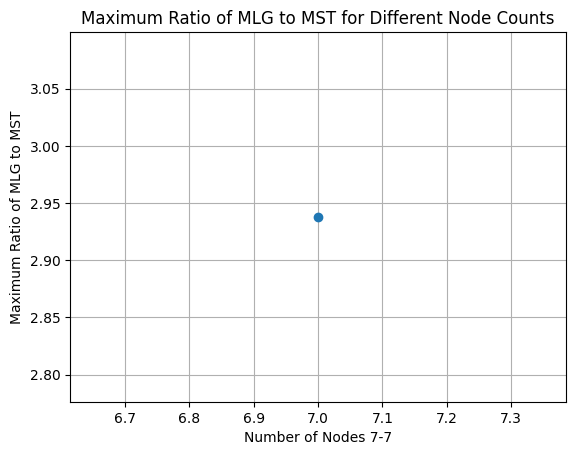

In [52]:
mst_ratio_search(100000, 7,7)
